In [1]:
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.manifold import *
from sklearn.decomposition import *
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import metrics

from sknn.mlp import Classifier, Layer

%matplotlib inline

In [2]:
# Load the data
df = pd.read_csv('Data/Output 2016-07-12 15-25-20.csv')

n_rows, n_feat = df.shape
print("%i Features, %i Records" % (n_feat, n_rows))

X = df.ix[:,0:n_feat-1]
Y = pd.DataFrame(df.ix[:,n_feat-1])

labels = pd.get_dummies(Y)
Y.Class = Y.Class.astype('category')

# Use this data for classification (should be numpy array)
X_ = X.as_matrix()
Y_ = Y.Class.cat.codes.as_matrix()

# Split for training and testing
sss = StratifiedShuffleSplit(Y_, 3, test_size=0.5)

for train_index, test_index in sss:
    X_train, X_test = X_[train_index], X_[test_index]
    #Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
    Y_train, Y_test = Y_[train_index], Y_[test_index]

1275 Features, 1919 Records


In [3]:
cats = Y.Class.cat.categories
cats

Index([u'cityhall', u'deep1', u'deep2', u'fountain', u'gun', u'spurn',
       u'statue_family', u'statue_net', u'steam'],
      dtype='object')

In [4]:
Y_

array([0, 0, 0, ..., 8, 8, 8], dtype=int8)

In [5]:
# Compute LLE
print("Computing LLE embedding")
t0 = time()
X_LLE, err = locally_linear_embedding(X_, n_neighbors=20, n_components=2, method="standard")
#X_LLE = pd.DataFrame(X_LLE)
t1 = time()
print("Done. Reconstruction error: %g. Time %.2f sec" % ( err, (t1 - t0)))


Computing LLE embedding
Done. Reconstruction error: 1.68674e-05. Time 7.77 sec


In [6]:
saveDF = pd.DataFrame(X_LLE)
#saveDF.to_csv('IET_Paper/LLE_Data.csv')

In [7]:
# Load the data (needed for the paper)
#X_LLE = pd.read_csv('IET_Paper/LLE_Data.csv')
#X_LLE = X_LLE.ix[:,1:3]
#X_LLE = X_LLE.as_matrix()

In [8]:
for train_index, test_index in sss:
    X_LLE_train, X_LLE_test = X_LLE[train_index], X_LLE[test_index]
    #Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
    Y_LLE_train, Y_LLE_test = Y_[train_index], Y_[test_index]


## Display LLE Data

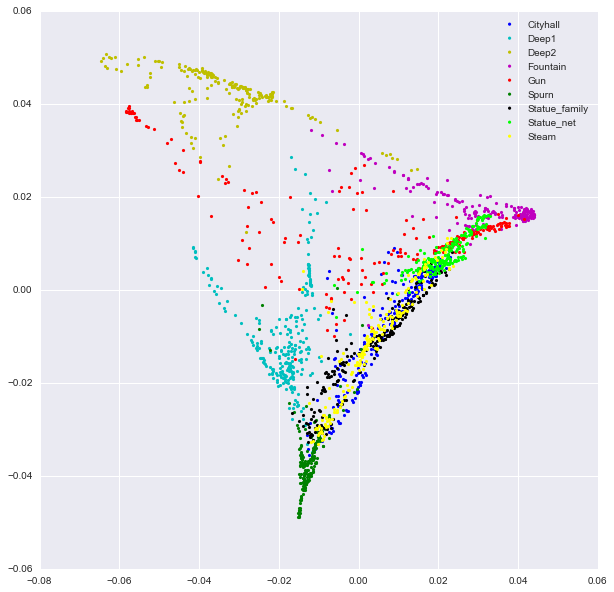

In [9]:
cats  = list(cats)
cats

plt.figure(figsize=(10,10))
colors = ['b', 'c', 'y', 'm', 'r', 'g','k','lime','yellow']
count = 0
for i in cats:
    #print(i)
    idx = df[df.Class == i].index.values
    #print(idx)
    test = plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c=colors[count], s=10, lw = 0, label=i.capitalize())
    count = count + 1

plt.legend()
plt.savefig('IET_Paper/LocalLinearEmbedding.pdf')

In [10]:
print(enumerate(cats))

## Neural Network

In [11]:
nn = Classifier(
    layers=[
        Layer("Sigmoid", units=500),
        Layer("Sigmoid", units=200),
        Layer("Sigmoid", units=50),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=100)
nn.fit(X_train, Y_train)

/Users/johnstamford/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Sigmoid`: units=500, name=u'hidden0', frozen=False>,
      hidden1=<sknn.nn.Layer `Sigmoid`: units=200, name=u'hidden1', frozen=False>,
      hidden2=<sknn.nn.Layer `Sigmoid`: units=50, name=u'hidden2', frozen=False>,
      layers=[<sknn.nn.Layer `Sigmoid`: units=500, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Sigmoid`: units=200, name=u'hidden1', frozen=False>, <sknn.nn.Layer `Sigmoid`: units=50, name=u'hidden2', frozen=False>, <sknn.nn.Layer `Softmax`: units=9, name=u'output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.001, learning_rule=u'sgd',
      loss_type=None, n_iter=100, n_stable=10, normalize=None,
      output=<sknn.nn.Layer `Softmax`: units=9, name=u'output', frozen=False>,
      parameters=None, random_state=None, regularize=None, valid_set=None,
      valid_size=0.0, verbose=None, warning=None, weight_decay=None)

In [42]:
# IGNORE THESES RESULTS
# ITERATION REDUCED TO 10 TO SPEED UP - SHOULD BE IGNORED
'''
nn_lle = Classifier(
    layers=[
        Layer("Sigmoid", units=20),
        Layer("Sigmoid", units=10),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=100)
nn_lle.fit(X_LLE_train, Y_train)
'''

'\nnn_lle = Classifier(\n    layers=[\n        Layer("Sigmoid", units=20),\n        Layer("Sigmoid", units=10),\n        Layer("Softmax")],\n    learning_rate=0.001,\n    n_iter=100)\nnn_lle.fit(X_LLE_train, Y_train)\n'

[(962, 9)]
[(962, 9)]
[(1919, 9)]
[(1919, 9)]
[(957, 9)]
[(957, 9)]


'\npred_LLE_test = nn_lle.predict(X_LLE_test)\npred_LLE_test_proba = nn_lle.predict_proba(X_LLE_test)\n\npred_LLE_train = nn_lle.predict(X_LLE_train)\npred_LLE_train_proba = nn_lle.predict_proba(X_LLE_train)\n\nfpr_LLE_test, tpr_LLE_test, thresholds = metrics.roc_curve(Y_test, pred_LLE_test_proba[:,0], pos_label=2)\nfpr_LLE_train, tpr_LLE_train, thresholds = metrics.roc_curve(Y_train, pred_LLE_train_proba[:,0], pos_label=2)\n\nplt.subplot(122)\nplt.plot(tpr_LLE_test, fpr_LLE_test)\nplt.plot(tpr_LLE_train, fpr_LLE_train)\n'

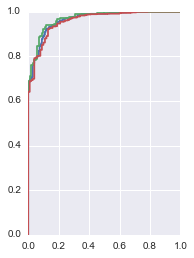

In [12]:
pred_test = nn.predict(X_test)
pred_test_proba = nn.predict_proba(X_test)

pred_all = nn.predict(X_)
pred_all_proba = nn.predict_proba(X_)

pred_train = nn.predict(X_train)
pred_train_proba = nn.predict_proba(X_train)

fpr_all, tpr_all, thresholds = metrics.roc_curve(Y_, pred_all_proba[:,0], pos_label=2)
fpr_test, tpr_test, thresholds = metrics.roc_curve(Y_test, pred_test_proba[:,0], pos_label=2)
fpr_train, tpr_train, thresholds = metrics.roc_curve(Y_train, pred_train_proba[:,0], pos_label=2)

plt.subplot(121)
plt.plot(tpr_all, fpr_all)
plt.plot(tpr_test, fpr_test)
plt.plot(tpr_train, fpr_train)

# LLE Model
'''
pred_LLE_test = nn_lle.predict(X_LLE_test)
pred_LLE_test_proba = nn_lle.predict_proba(X_LLE_test)

pred_LLE_train = nn_lle.predict(X_LLE_train)
pred_LLE_train_proba = nn_lle.predict_proba(X_LLE_train)

fpr_LLE_test, tpr_LLE_test, thresholds = metrics.roc_curve(Y_test, pred_LLE_test_proba[:,0], pos_label=2)
fpr_LLE_train, tpr_LLE_train, thresholds = metrics.roc_curve(Y_train, pred_LLE_train_proba[:,0], pos_label=2)

plt.subplot(122)
plt.plot(tpr_LLE_test, fpr_LLE_test)
plt.plot(tpr_LLE_train, fpr_LLE_train)
'''

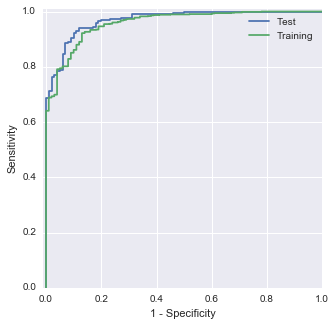

In [36]:
plt.figure(figsize=(5,5)) 
#plt.plot(tpr_all, fpr_all, label="All")
plt.plot(tpr_test, fpr_test, label="Test")
plt.plot(tpr_train, fpr_train, label="Training")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.legend()
#plt.savefig('IET_Paper/ROC2.pdf')

In [27]:
print "Test AUC %.3f:" % metrics.auc(tpr_test, fpr_test)
print "Train AUC %.3f:" % metrics.auc(tpr_train, fpr_train)

Test AUC 0.970:
Train AUC 0.959:


In [45]:
pd.crosstab(Y_test, pred_test[:,0], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,All
True,,,,,,,,,,
0,73,0,0,0,0,7,10,15,0,105
1,0,123,4,0,0,3,0,0,0,130
2,0,0,91,2,3,0,0,4,0,100
3,0,1,2,77,15,0,0,11,0,106
4,0,17,12,19,41,0,0,2,14,105
5,6,0,0,0,0,93,2,0,2,103
6,10,0,0,0,0,10,72,12,0,104
7,8,3,0,5,2,0,3,84,0,105
8,0,2,6,9,15,3,0,3,66,104


In [46]:
# Which are correct
outcomes = pd.DataFrame({'TrueVal' : Y_, 'PredVal' : pred_all[:,0], 'Correct': np.nan})
outcomes = outcomes[[2,1,0]]

outcomes.Correct = 0
outcomes.loc[outcomes['TrueVal'] == outcomes['PredVal'], 'Correct'] = 1



In [47]:
pd.crosstab(Y_, pred_all[:,0], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,All
True,,,,,,,,,,
0,148,1,0,0,0,17,15,28,0,209
1,0,247,7,0,0,6,0,0,0,260
2,0,0,184,2,7,0,0,6,1,200
3,0,1,3,161,29,0,0,18,0,212
4,0,25,17,47,88,0,1,2,29,209
5,9,0,0,0,0,184,8,0,4,205
6,28,4,0,0,0,23,134,18,0,207
7,13,3,0,6,4,0,5,179,0,210
8,0,2,11,12,29,4,0,3,146,207


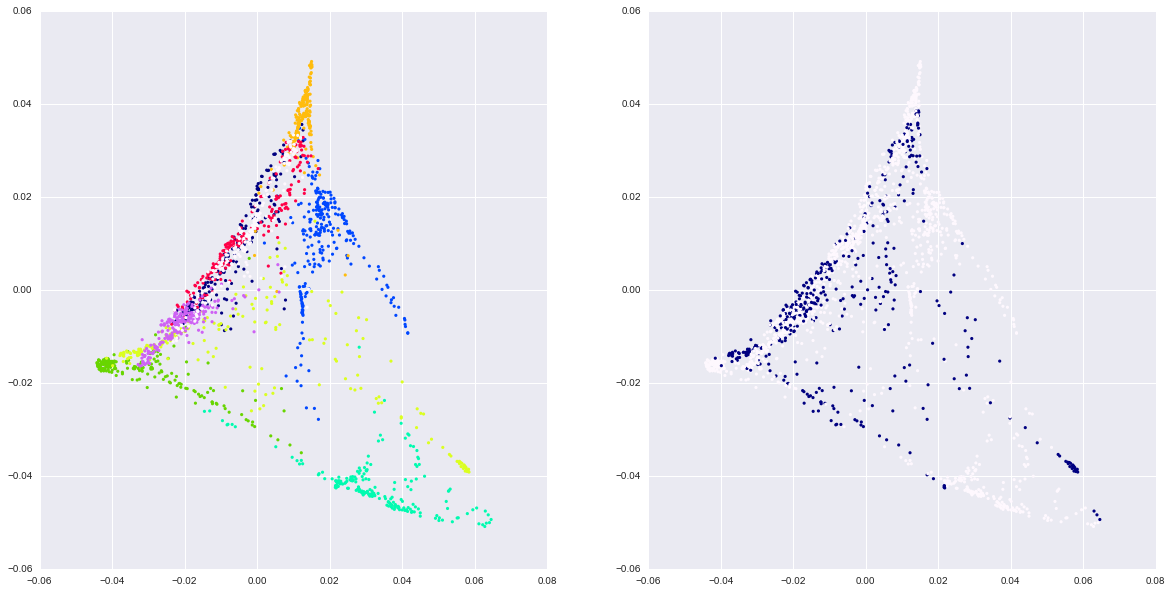

In [48]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(X_LLE[:,0],X_LLE[:,1], c=Y.Class.cat.codes, cmap='gist_ncar', s=10, lw = 0)
plt.subplot(122)
plt.scatter(X_LLE[:,0],X_LLE[:,1], c=outcomes.Correct, cmap='gist_ncar', s=10, lw = 0)

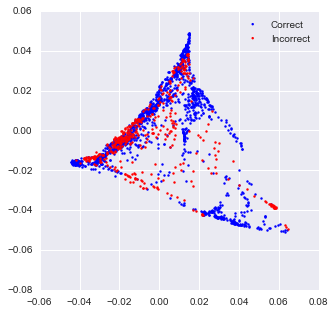

In [49]:
plt.figure(figsize=(5,5))
colors = ['b', 'c', 'y', 'm', 'r', 'g','k','lime','yellow']

idx = df[outcomes.Correct == 1].index.values
plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c='b', s=6, lw = 0, label='Correct')

idx = df[outcomes.Correct == 0].index.values
plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c='r', s=6, lw = 0, label='Incorrect')

plt.legend()
#plt.savefig('IET_Paper/Incorrect_Classes.pdf')

In [97]:
files = pd.read_csv('../Data/LapsitData/data.csv')

NameError: name 'files' is not defined

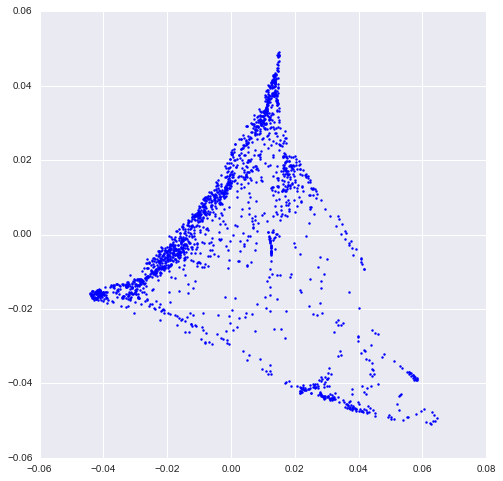

In [50]:
plt.figure(figsize=(8,8))
colors = ['b', 'c', 'y', 'm', 'r', 'g','k','lime','yellow']


plt.scatter(X_LLE[:,0],X_LLE[:,1], c='b', s=6, lw = 0, label='Correct')

idx = files[files.File == 'Proj5_img00000002.jpg'].index.values
plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c='r', s=6, lw = 0, label='Incorrect')

plt.legend()
#plt.savefig('IET_Paper/Incorrect_Classes.pdf')

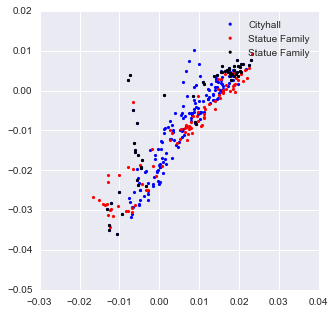

In [159]:
plt.figure(figsize=(5,5))
colors = ['b', 'g', 'g','k','lime','yellow']
count = 0

idx = df[df.Class == 'statue_family'].index.values
#plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c='g', s=10, lw = 0, label='Statue Fammily')

idx = df[df.Class == 'cityhall'].index.values
plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c='b', s=10, lw = 0, label='Cityhall')        

idx = df[(df.Class == 'statue_family') & (outcomes.Correct == 0)].index.values
plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c='r', s=10, lw = 0, label='Statue Family')        

idx = df[(df.Class == 'cityhall') & (outcomes.Correct == 0)].index.values
plt.scatter(X_LLE[idx,0],X_LLE[idx,1], c='k', s=10, lw = 0, label='Statue Family')

plt.legend()
#plt.savefig('IET_Paper/CityHallAndStatue_Results.pdf')